# Inter-Class

> Relationship between different classes

In [ ]:
#| hide
from nbdev.showdoc import *

In [2]:
from sklearn.decomposition import PCA
from scipy.stats import norm
from fastai.vision.all import *

from similarity_learning.all import *

from Few_Shot_Feature_Space.utils import *

In [3]:
def per_component_hist(xs, n_plots):
    pca = PCA()
    pca.fit(xs.cpu())
    
    fig, axs = plt.subplots(n_plots, 1)
    fig.tight_layout()
    
    comp_idxs = [i*pca.n_components_//(n_plots-1) for i in range(n_plots-1)] + [pca.n_components_-1]
    for comp_idx, ax in zip(comp_idxs, axs):
        dir = Tensor(pca.components_[comp_idx]).cuda()
        angles = (xs @ dir).cpu()
        plot_hist(angles, ax=ax)
        ax.set_title(f'Component #{comp_idx+1} out of {pca.n_components_}')

## Class Means

In [4]:
def plot(dl, fe, n_plots=4):
    class_ftrs = ClassFeatures.compute(dl, fe)
    centroids = torch.stack([f.centroid for f in class_ftrs.values()])
    per_component_hist(centroids, n_plots)

In [5]:
vggface2_fe, casia_webface_fe = fr_feature_extractors()
lfw_dl, pfr_dl = fr_dataloaders()

## VGGFace2

### LFW

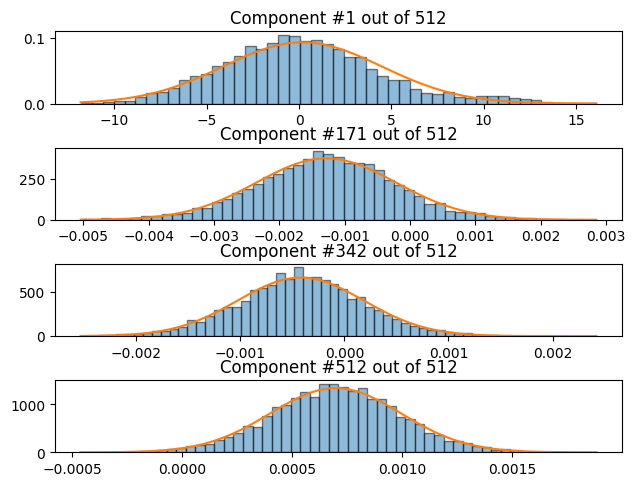

In [6]:
plot(lfw_dl, vggface2_fe)

### PFR

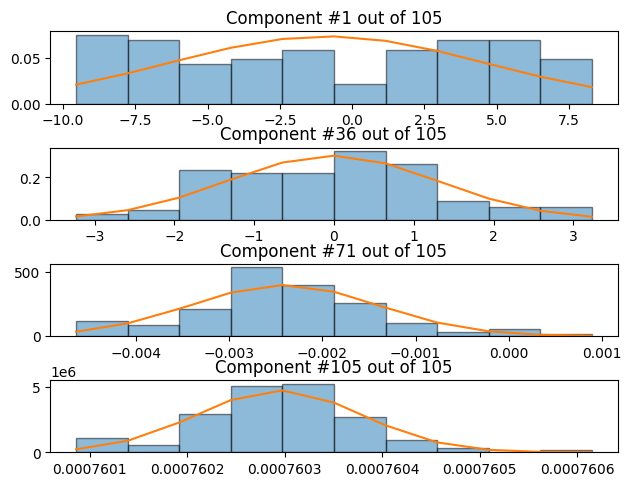

In [7]:
plot(pfr_dl, vggface2_fe, bins=10)

## CASIA-WebFace

### LFW

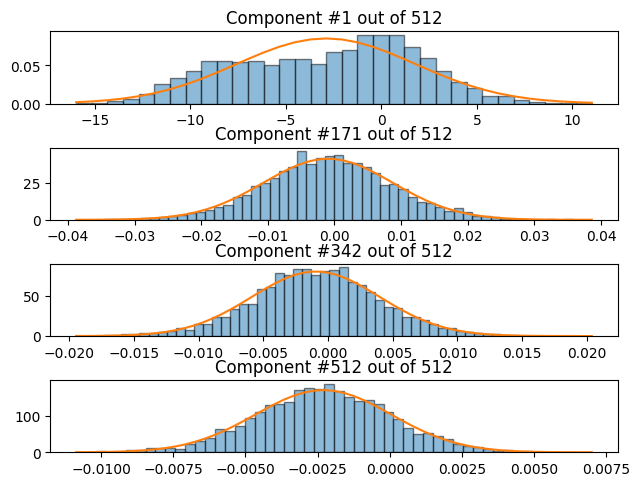

In [8]:
plot(lfw_dl, casia_webface_fe)

### PFR

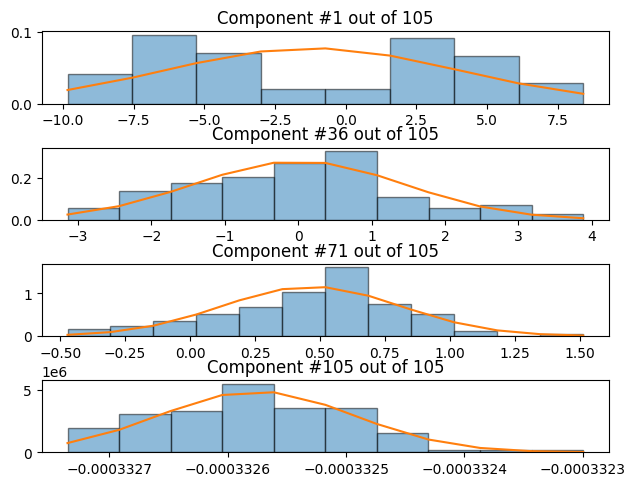

In [9]:
plot(pfr_dl, casia_webface_fe)